In [1]:

import matplotlib.pyplot as plt
import scanpy as sc
import numpy as np
import time


In [2]:
import decoupler as dc
import pandas as pd
import sys
import pickle
import tqdm
import scipy
import anndata

import pydeseq2
from pydeseq2.dds import DeseqDataSet
from pydeseq2.default_inference import DefaultInference
from pydeseq2.ds import DeseqStats
inference = DefaultInference(n_cpus=8)

In [3]:
import pickle
with open('/home/ec2-user/curation/heart_datasets/gg_250821_heart_data_split_by_xist.p', 'rb') as fp:
    ads = pickle.load( fp)


Note that this inference procedure is relatively unstable. See https://github.com/owkin/PyDESeq2/issues/391.

If floats are passed in as the data matrix `ad.X`, the standard optimization procedure fails and falls back on a more stable grid search. If ints are passed, the likelihood landscape is too flat to get to the optimum. In a newer version of PyDESeq2, the data are cast to int by default, resulting in suboptimal inferences.



# DE

In [4]:
def build_consensus_ad(ads,filter_by = 'xist'):
    consensus_genes = set(ads[list(ads.keys())[0]].var_names)
    for i,dataset in enumerate(ads.keys()):
        consensus_genes = consensus_genes&set(ads[dataset].var_names)
        
    ads_filt = {}
    for i,dataset in enumerate(ads.keys()):
        ads_filt[dataset] = ads[dataset][:,list(consensus_genes)].copy()
        ads_filt[dataset].obs['dataset'] = dataset
    
        if 'age' in ads_filt[dataset].obs.columns:
            pass
        elif 'Age_bin' in ads_filt[dataset].obs.columns:
            x1 = ads_filt[dataset].obs['Age_bin'].str.split('-').str[1].astype(float)
            x2 = ads_filt[dataset].obs['Age_bin'].str.split('-').str[0].astype(float)
            x = (x1+x2)/2
            ads_filt[dataset].obs['age'] = x
    ad=anndata.concat([ads_filt[x] for x in ads_filt.keys()])
    if filter_by=='xist':
        ad.obs['donor_id'] = ad.obs['donor_id']+'_'+ad.obs['dataset']
        ad.obs_names_make_unique()
        return ad

In [5]:
ad=build_consensus_ad(ads)

/home/ec2-user/miniconda/lib/python3.9/site-packages/anndata/_core/anndata.py:1897: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [6]:
df_ensembl = pd.read_csv('/home/ec2-user/platform/anno/gene_details_ensembl_v104.txt',sep='\t').set_index('ensembl_id')
dict_ensembl = dict(df_ensembl[['gene_symbol', 'chromosome_name']].values)

In [7]:
# ad.X=ad.X.astype(int)

In [8]:
ad.obs

,donor_id,xist,sex,age,psbulk_n_cells,psbulk_counts,dataset
TWCM-190-R-post_absent,TWCM-190-R-post_amrute,absent,male,18,6.0,7190.0,amrute
TWCM-190-R-pre_absent,TWCM-190-R-pre_amrute,absent,male,18,64.0,98084.0,amrute
TWCM-229-R-post_absent,TWCM-229-R-post_amrute,absent,male,60,9.0,12746.0,amrute
TWCM-229-R-pre_absent,TWCM-229-R-pre_amrute,absent,male,60,5.0,8032.0,amrute
TWCM-239-R-post_absent,TWCM-239-R-post_amrute,absent,male,44,7.0,10203.0,amrute
...,...,...,...,...,...,...,...
1600_present,1600_tucker,present,female,51,89.0,128194.0,tucker
1666_present,1666_tucker,present,male,54,43.0,45612.0,tucker
1681_present,1681_tucker,present,male,39,96.0,127180.0,tucker
1708_present,1708_tucker,present,female,60,62.0,68904.0,tucker


In [9]:
ad.X

array([[  2.,   0.,   1., ...,   0.,   1.,   0.],
       [  2.,   3.,  12., ...,   7.,   3.,  28.],
       [  0.,   0.,   1., ...,   0.,   1.,   2.],
       ...,
       [  0.,   4.,   6., ...,   4.,   3.,  27.],
       [  0.,   0.,   1., ...,   1.,   1.,  11.],
       [  3.,  13.,  17., ...,  24.,   2., 116.]], dtype=float32)

In [10]:
t1=time.time()
ad_ = ad[ad.obs['sex'] =='female'].copy() #get female donors
vc = ad_.obs['donor_id'].value_counts()
vc = vc[vc==2] #filter for those with XIST+ and XIST- cells
ad_f = ad_[ad_.obs['donor_id'].isin(vc.index)]

In [11]:
dds_f = DeseqDataSet(
    adata=ad_f.copy(),
    design_factors=['xist','donor_id'],
    refit_cooks=True,
    inference=inference,
    quiet=False)


/tmp/ipykernel_5303/4060663907.py:1: UserWarning: Same factor names in the design contain underscores ('_'). They will
                be converted to hyphens ('-').
  dds_f = DeseqDataSet(
/home/ec2-user/miniconda/lib/python3.9/site-packages/pydeseq2/dds.py:262: UserWarning: Some factor levels in the design contain underscores ('_').
                    They will be converted to hyphens ('-').
  self.obsm["design_matrix"] = build_design_matrix(


In [13]:
dds_f.deseq2()

Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 467.83 seconds.

Fitting dispersion trend curve...
... done in 3.13 seconds.

Fitting MAP dispersions...
... done in 421.28 seconds.

Fitting LFCs...
... done in 12.15 seconds.

Replacing 0 outlier genes.



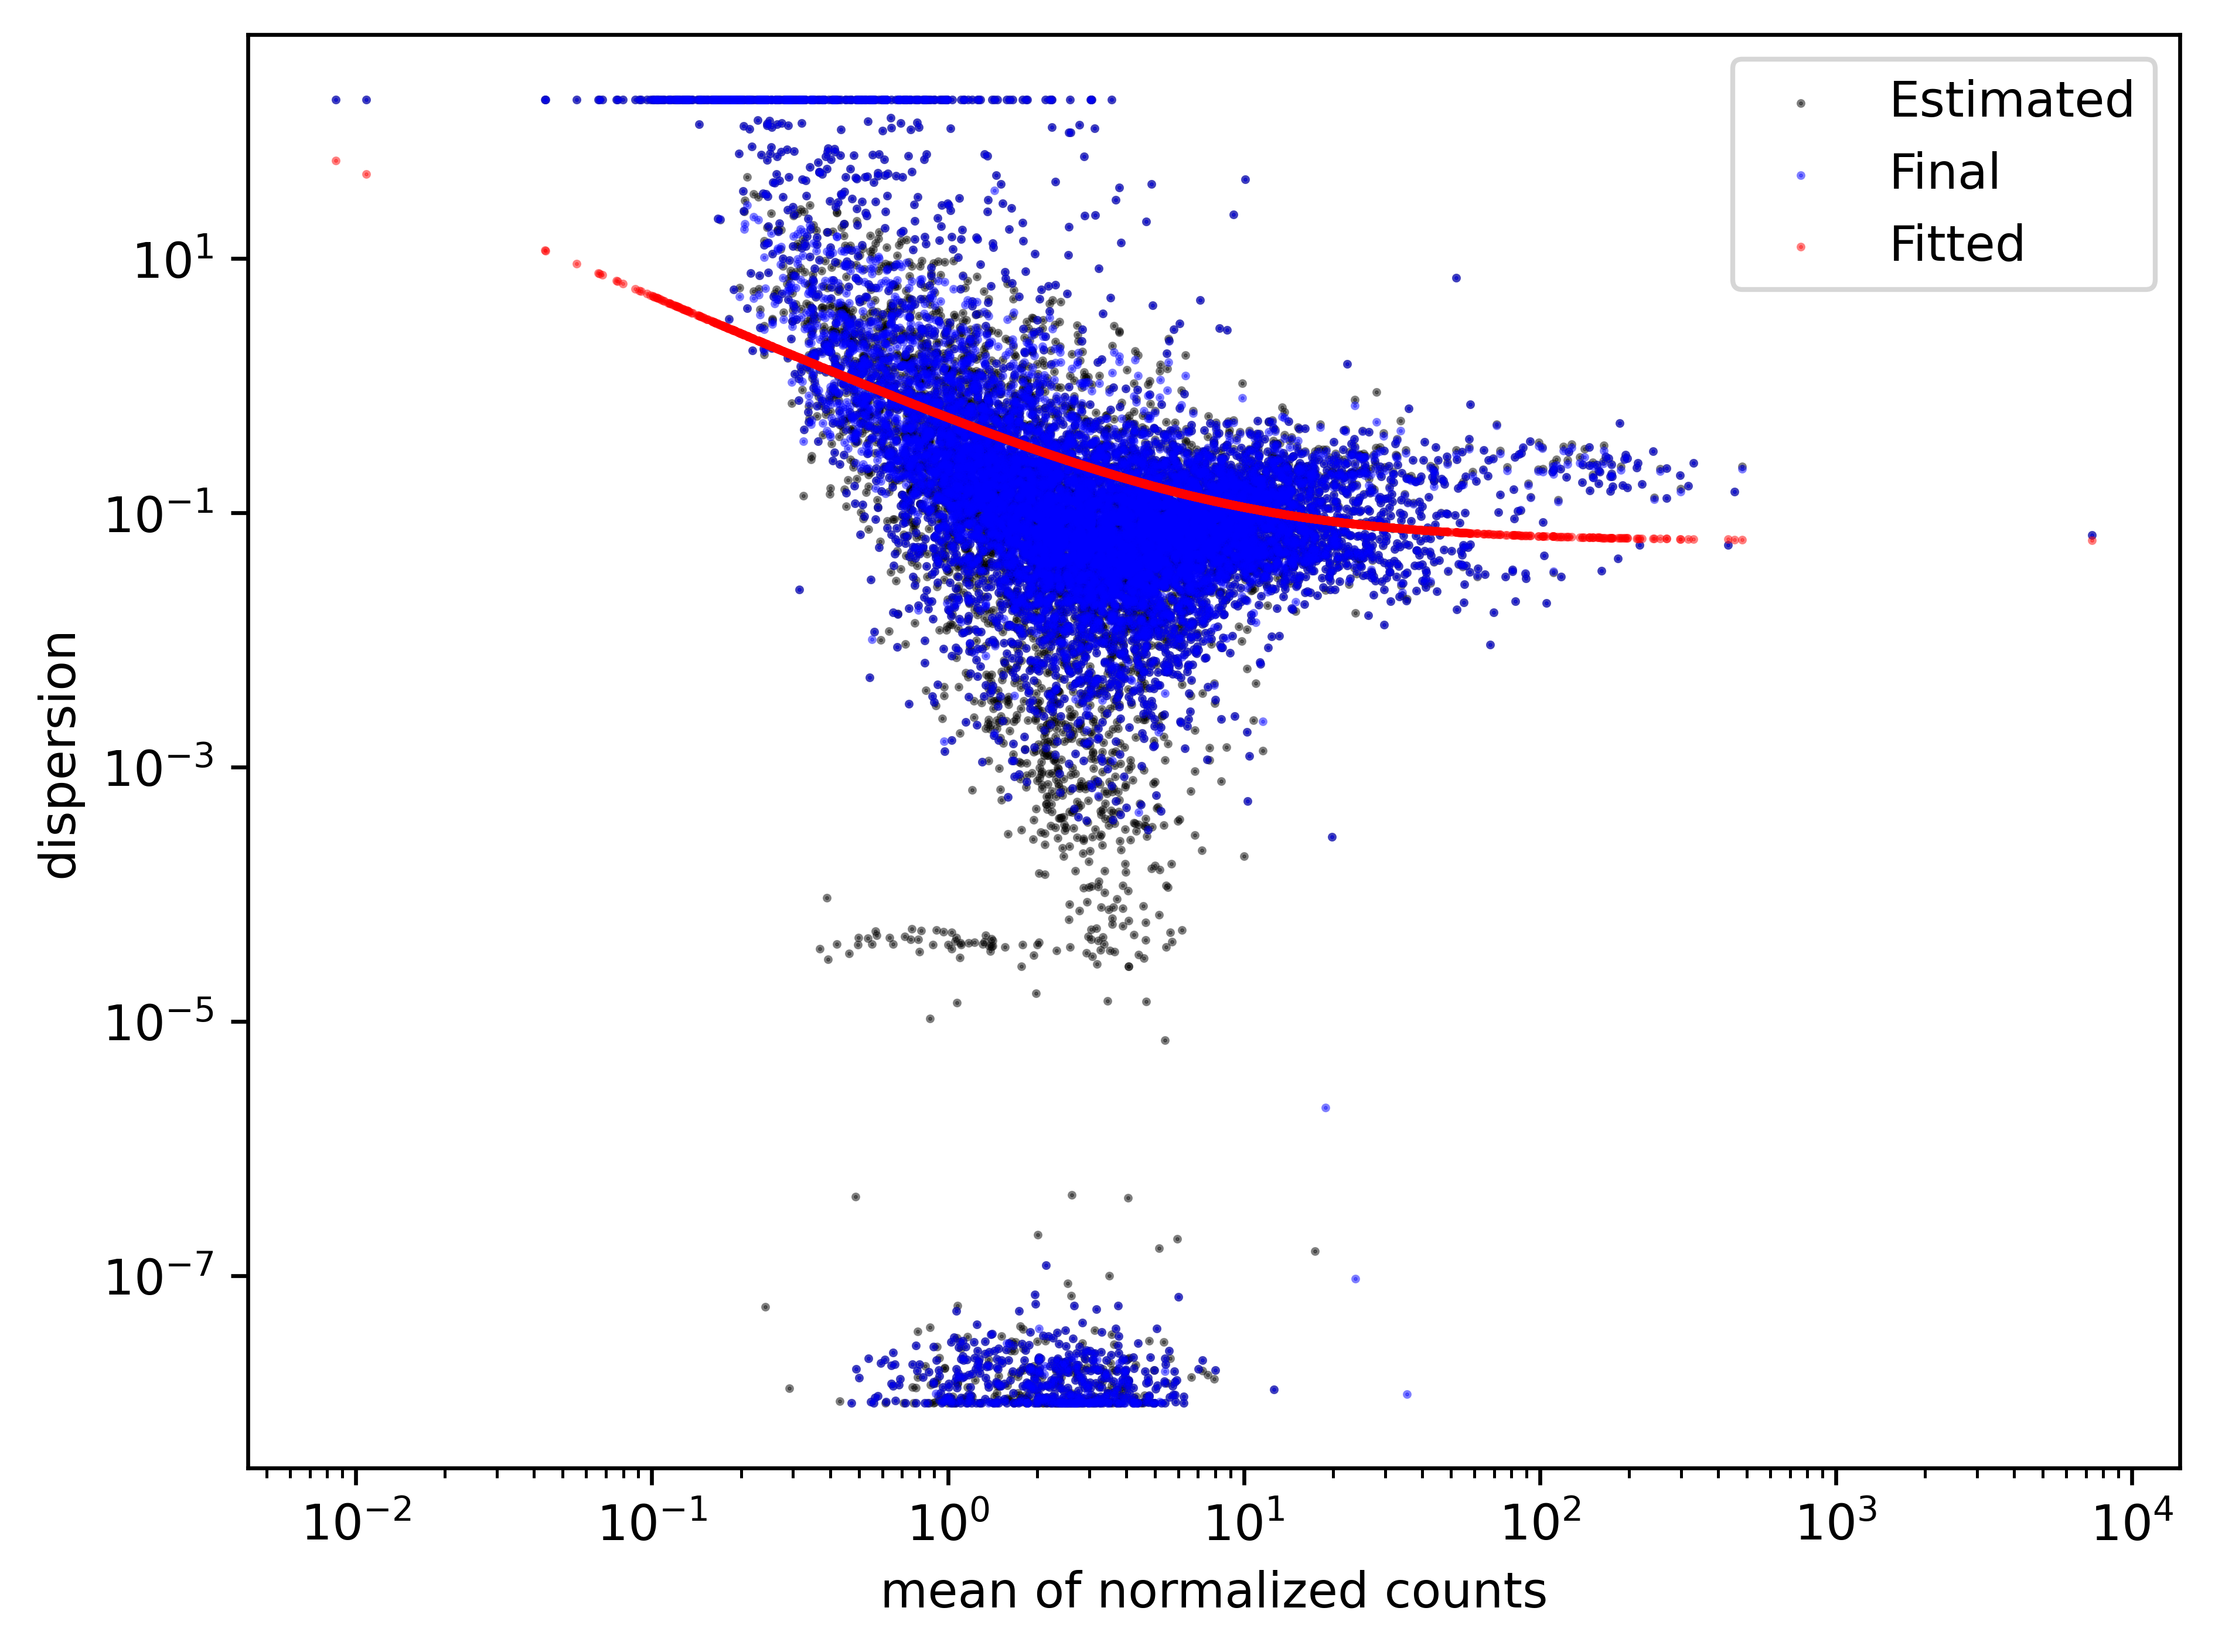

In [14]:
dds_f.plot_dispersions()

In [15]:

stat_res_Y_vs_X = DeseqStats(dds_f, contrast=["xist", "present", "absent"], inference=inference,quiet=True)
stat_res_Y_vs_X.summary()
res_f = stat_res_Y_vs_X.results_df
df_ensembl = pd.read_csv('/home/ec2-user/platform/anno/gene_details_ensembl_v104.txt',sep='\t').set_index('ensembl_id')
dict_ensembl = dict(df_ensembl[['gene_symbol', 'chromosome_name']].values)

res_f['chr'] = res_f.index.map(dict_ensembl)
res_f.to_csv('/home/ec2-user/curation/heart_datasets/deseq/gg_250821_xist_pres_vs_abs_donor_id_2samp_female.csv')
with open('/home/ec2-user/curation/heart_datasets/gg_250821_female_glia_deseq.anndata.p', 'wb') as fp:
    pickle.dump(dds_f,fp)
t2=time.time()
print('Runtime: {:.2f} minutes.'.format((t2-t1)/60))

Log2 fold change & Wald test p-value: xist present vs absent
          baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
CRTC2     0.728046       -0.455058  0.282076 -1.613246  0.106691  0.314349
ID4       9.472535       -0.205666  0.162617 -1.264726  0.205969  0.444634
ATP11C    3.337033       -0.016457  0.124952 -0.131704  0.895218  0.950709
MEIS1     7.039235        0.034246  0.183964  0.186156  0.852323  0.928276
ZNF516    4.280186        0.003882  0.112455  0.034519  0.972463  0.988459
...            ...             ...       ...       ...       ...       ...
ANKRD46   3.294261       -0.100549  0.178955 -0.561868  0.574206  0.770017
LGR5      0.612405       -1.476615  0.486096 -3.037703  0.002384  0.065470
PCNP      7.431108        0.145089  0.150440  0.964429  0.334831  0.581290
SYVN1     1.056456       -0.679869  0.234181 -2.903176  0.003694  0.075865
UBR3     13.774071        0.025003  0.071789  0.348280  0.727630  0.858840

[10391 rows x 6 columns]
Runtime: 15.4

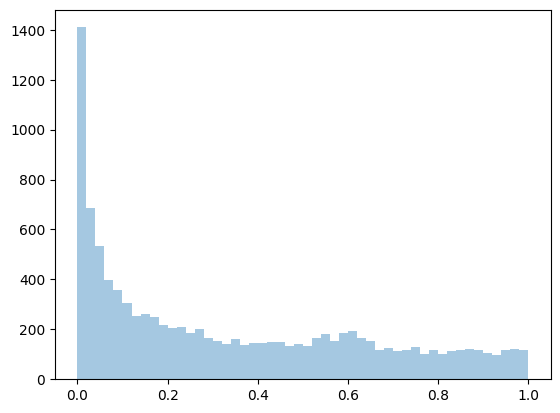

In [16]:
plt.hist(res_f['pvalue'],50,alpha=0.4)
plt.show()

In [17]:
len(res_f[(res_f['baseMean']>5)&(res_f['padj']<0.05)].sort_values('padj'))

76

(-1.0, 10.0)

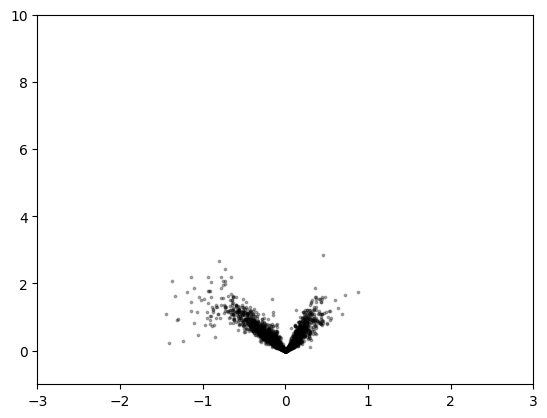

In [18]:
gf = res_f['baseMean']>5
plt.scatter(res_f.loc[gf,'log2FoldChange'],-np.log10(res_f.loc[gf,'padj']),3,'k',alpha=0.3)
plt.xlim([-3,3])
plt.ylim([-1,10])

In [19]:
t1=time.time()
ad_ = ad[ad.obs['sex'] =='male'].copy() #get male donors
vc = ad_.obs['donor_id'].value_counts()
vc = vc[vc==2] #filter for those with XIST+ and XIST- cells
ad_m = ad_[ad_.obs['donor_id'].isin(vc.index)]
dds_m = DeseqDataSet(
    adata=ad_m.copy(),
    design_factors=['donor_id','xist'],
    refit_cooks=True,
    inference=inference,
    quiet=False)

/tmp/ipykernel_5303/2080046646.py:6: UserWarning: Same factor names in the design contain underscores ('_'). They will
                be converted to hyphens ('-').
  dds_m = DeseqDataSet(
/home/ec2-user/miniconda/lib/python3.9/site-packages/pydeseq2/dds.py:262: UserWarning: Some factor levels in the design contain underscores ('_').
                    They will be converted to hyphens ('-').
  self.obsm["design_matrix"] = build_design_matrix(


In [ ]:
dds_m.deseq2()

Fitting size factors...
... done in 0.05 seconds.

Fitting dispersions...


In [ ]:
dds_m.plot_dispersions()

In [ ]:
stat_res_Y_vs_X = DeseqStats(dds_m, contrast=["xist", "present", "absent"], inference=inference,quiet=True)
stat_res_Y_vs_X.summary()
res_m = stat_res_Y_vs_X.results_df
df_ensembl = pd.read_csv('/home/ec2-user/platform/anno/gene_details_ensembl_v104.txt',sep='\t').set_index('ensembl_id')
dict_ensembl = dict(df_ensembl[['gene_symbol', 'chromosome_name']].values)

res_m['chr'] = res_m.index.map(dict_ensembl)
res_m.to_csv('/home/ec2-user/curation/heart_datasets/deseq/gg_250821_xist_pres_vs_abs_donor_id_2samp_male.csv')
with open('/home/ec2-user/curation/heart_datasets/gg_250821_male_glia_deseq.anndata.p', 'wb') as fp:
    pickle.dump(dds_m,fp)
t2=time.time()
print('Runtime: {:.2f} minutes.'.format((t2-t1)/60))

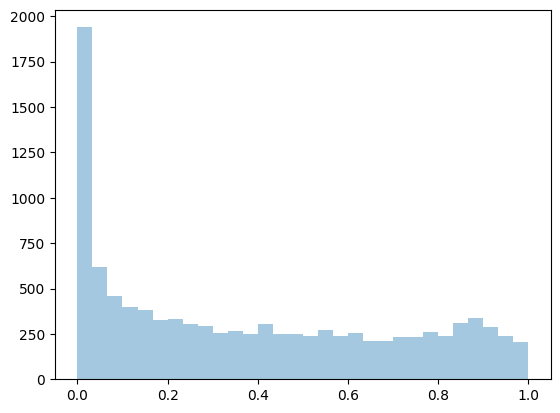

In [26]:
plt.hist(res_m['pvalue'],30,alpha=0.4)
plt.show()

(-1.0, 10.0)

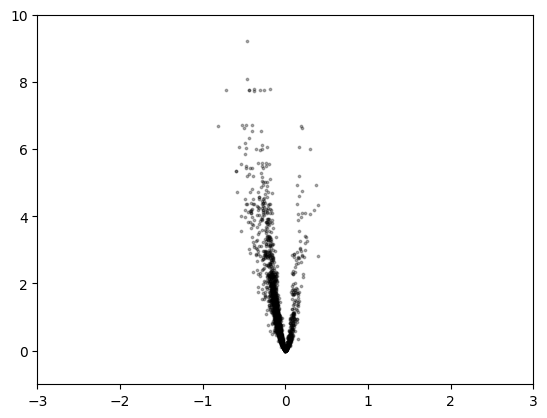

In [27]:
gf = res_m['baseMean']>5
plt.scatter(res_m.loc[gf,'log2FoldChange'],-np.log10(res_m.loc[gf,'padj']),3,'k',alpha=0.3)
plt.xlim([-3,3])
plt.ylim([-1,10])